In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import tqdm
from time import sleep
import time
from PIL import Image
from io import BytesIO
from adjustText import adjust_text
from scipy.interpolate import interp1d
from math import pi

In [3]:
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name, get_teams, find_team_name_by_id
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

In [4]:
boston_id = find_teams_by_full_name('Boston Celtics')[0]['id']
boston_id

1610612738

In [5]:
boston_playoff_games = LeagueGameFinder(season_nullable='2019-20', player_or_team_abbreviation='T', 
                                        team_id_nullable=boston_id, season_type_nullable='Playoffs')
boston_playoff_games_df = boston_playoff_games.get_data_frames()[0]
boston_playoff_games_df

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,42019,1610612738,BOS,Boston Celtics,0041900306,2020-09-27,BOS @ MIA,L,240,113,...,0.800,13,29,42,26,7,2,10,21,-12.0
1,42019,1610612738,BOS,Boston Celtics,0041900305,2020-09-25,BOS vs. MIA,W,238,121,...,0.862,13,37,50,29,7,4,11,23,13.0
2,42019,1610612738,BOS,Boston Celtics,0041900304,2020-09-23,BOS @ MIA,L,239,109,...,0.810,12,34,46,28,3,5,19,24,0.2
3,42019,1610612738,BOS,Boston Celtics,0041900303,2020-09-19,BOS @ MIA,W,240,117,...,0.867,10,40,50,27,8,3,14,29,8.4
4,42019,1610612738,BOS,Boston Celtics,0041900302,2020-09-17,BOS vs. MIA,L,240,101,...,0.792,6,35,41,19,5,3,20,22,-5.0
5,42019,1610612738,BOS,Boston Celtics,0041900301,2020-09-15,BOS vs. MIA,L,264,114,...,0.913,6,31,37,24,9,6,10,25,-3.2
6,42019,1610612738,BOS,Boston Celtics,0041900217,2020-09-11,BOS @ TOR,W,240,92,...,0.565,10,34,44,19,12,5,10,16,5.0
7,42019,1610612738,BOS,Boston Celtics,0041900216,2020-09-09,BOS vs. TOR,L,290,122,...,0.833,14,44,58,32,5,4,15,25,-3.0
8,42019,1610612738,BOS,Boston Celtics,0041900215,2020-09-07,BOS @ TOR,W,238,111,...,0.889,4,41,45,23,5,6,11,19,22.0
9,42019,1610612738,BOS,Boston Celtics,0041900214,2020-09-05,BOS vs. TOR,L,240,93,...,0.741,6,39,45,18,6,2,14,20,-7.0


In [6]:
boston_playoff_games_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS'],
      dtype='object')

In [7]:
boston_playoff_games_df['HOME_AWAY'] = "-"
for i in range(0, len(boston_playoff_games_df)):
    if boston_playoff_games_df.loc[:, 'MATCHUP'][i][4:6] == '@ ':
        boston_playoff_games_df.loc[:,'HOME_AWAY'][i] = 'A'
    else:
        boston_playoff_games_df.loc[:,'HOME_AWAY'][i] = 'H'

<ipython-input-7-b22d7c1f3413>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_playoff_games_df.loc[:,'HOME_AWAY'][i] = 'A'
<ipython-input-7-b22d7c1f3413>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_playoff_games_df.loc[:,'HOME_AWAY'][i] = 'H'


In [8]:
#boston_playoff_games_df.reset_index(drop=True, inplace=True)
boston_playoff_games_df = boston_playoff_games_df.sort_values(by='GAME_DATE')

In [9]:
boston_playoff_games_df.iloc[:, :]

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,HOME_AWAY
16,42019,1610612738,BOS,Boston Celtics,0041900121,2020-08-17,BOS vs. PHI,W,239,109,...,16,27,43,22,12,4,7,21,8.0,H
15,42019,1610612738,BOS,Boston Celtics,0041900122,2020-08-19,BOS vs. PHI,W,241,128,...,10,33,43,20,4,5,6,28,27.0,H
14,42019,1610612738,BOS,Boston Celtics,0041900123,2020-08-21,BOS @ PHI,W,240,102,...,3,42,45,15,7,8,10,23,8.0,A
13,42019,1610612738,BOS,Boston Celtics,0041900124,2020-08-23,BOS @ PHI,W,240,110,...,10,32,42,19,4,5,14,25,4.0,A
12,42019,1610612738,BOS,Boston Celtics,0041900211,2020-08-30,BOS @ TOR,W,240,112,...,5,45,50,25,8,4,22,22,18.0,A
11,42019,1610612738,BOS,Boston Celtics,0041900212,2020-09-01,BOS @ TOR,W,241,102,...,4,40,44,18,6,9,17,20,3.0,A
10,42019,1610612738,BOS,Boston Celtics,0041900213,2020-09-03,BOS vs. TOR,L,239,103,...,7,37,44,21,6,7,14,16,-1.0,H
9,42019,1610612738,BOS,Boston Celtics,0041900214,2020-09-05,BOS vs. TOR,L,240,93,...,6,39,45,18,6,2,14,20,-7.0,H
8,42019,1610612738,BOS,Boston Celtics,0041900215,2020-09-07,BOS @ TOR,W,238,111,...,4,41,45,23,5,6,11,19,22.0,A
7,42019,1610612738,BOS,Boston Celtics,0041900216,2020-09-09,BOS vs. TOR,L,290,122,...,14,44,58,32,5,4,15,25,-3.0,H


In [10]:
boston_playoff_games_df['RIVAL'] = "-"
for i in range(0, len(boston_playoff_games_df)):
    if boston_playoff_games_df['HOME_AWAY'][i] == 'H':
        boston_playoff_games_df['RIVAL'][i] = boston_playoff_games_df.loc[:, 'MATCHUP'][i][7:]
    else:
        boston_playoff_games_df['RIVAL'][i] = boston_playoff_games_df.loc[:, 'MATCHUP'][i][6:]

<ipython-input-10-477d50fbd01a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_playoff_games_df['RIVAL'][i] = boston_playoff_games_df.loc[:, 'MATCHUP'][i][6:]
<ipython-input-10-477d50fbd01a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boston_playoff_games_df['RIVAL'][i] = boston_playoff_games_df.loc[:, 'MATCHUP'][i][7:]


In [11]:
boston_playoff_games_df.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS', 'HOME_AWAY',
       'RIVAL'],
      dtype='object')

In [12]:
grouped = boston_playoff_games_df.groupby(by=['HOME_AWAY', 'RIVAL'])
grouped_mean_df = grouped.agg(np.mean)
grouped_mean_df

TEAM_ID         MIN     PTS        FGM        FGA  \
HOME_AWAY RIVAL                                                           
A         MIA    1.610613e+09  239.666667  113.00  41.000000  88.666667   
          PHI    1.610613e+09  240.000000  106.00  37.000000  84.500000   
          TOR    1.610613e+09  239.750000  104.25  36.000000  80.500000   
H          MIA   1.610613e+09  247.333333  112.00  39.000000  84.333333   
           PHI   1.610613e+09  240.000000  118.50  41.000000  88.000000   
           TOR   1.610613e+09  256.333333  106.00  38.666667  86.000000   

                 FG_PCT       FG3M       FG3A   FG3_PCT        FTM  ...  \
HOME_AWAY RIVAL                                                     ...   
A         MIA    0.4640  12.666667  37.333333  0.340667  18.333333  ...   
          PHI    0.4385  10.000000  33.000000  0.300500  22.000000  ...   
          TOR    0.4480  13.000000  37.250000  0.348000  19.250000  ...   
H          MIA   0.4650  12.333333  36.000000  0.343333  21.666667  ...   
           PHI   0.4670  14.500000  37.000000  0.382500  22.000000  ...   
           TOR   0.4500  11.666667  36.666667  0.307667  17.000000  ...   

                   FT_PCT       OREB       DREB        REB        AST  \
HOME_AWAY RIVAL                                                         
A         MIA    0.825667  11.666667  34.333333  46.000000  27.000000   
          PHI    0.838000   6.500000  37.000000  43.500000  17.000000   
          TOR    0.796000   5.750000  40.000000  45.750000  21.250000   
H          MIA   0.855667   8.333333  34.333333  42.666667  24.000000   
           PHI   0.804500  13.000000  30.000000  43.000000  21.000000   
           TOR   0.778667   9.000000  40.000000  49.000000  23.666667   

                      STL       BLK        TOV         PF  PLUS_MINUS  
HOME_AWAY RIVAL                                                        
A         MIA    6.000000  3.333333  14.333333  24.666667   -1.133333  
          PHI    5.500000  6.500000  12.000000  24.000000    6.000000  
          TOR    7.750000  6.000000  15.000000  19.250000   12.000000  
H          MIA   7.000000  4.333333  13.666667  23.333333    1.600000  
           PHI   8.000000  4.500000   6.500000  24.500000   17.500000  
           TOR   5.666667  4.333333  14.333333  20.333333   -3.666667  

[6 rows x 21 columns]

In [13]:
grouped_mean_df.columns

Index(['TEAM_ID', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PLUS_MINUS'],
      dtype='object')

In [14]:
boston_playoff_df_radar = boston_playoff_games_df[['MATCHUP', 'FG_PCT', 'FG3_PCT', 'FT_PCT']]
boston_playoff_df_radar_grouped = boston_playoff_df_radar.groupby(by='MATCHUP').mean()
boston_playoff_df_radar_grouped

,FG_PCT,FG3_PCT,FT_PCT
MATCHUP,,,
BOS @ MIA,0.4640,0.340667,0.825667
BOS @ PHI,0.4385,0.300500,0.838000
BOS @ TOR,0.4480,0.348000,0.796000
BOS vs. MIA,0.4650,0.343333,0.855667
BOS vs. PHI,0.4670,0.382500,0.804500
BOS vs. TOR,0.4500,0.307667,0.778667


In [15]:
categories = ['FG_PCT', 'FG3_PCT', 'FT_PCT']

list_x = []
for i in range(0, len(boston_playoff_df_radar_grouped)):
        list_y = (boston_playoff_df_radar_grouped.iloc[i:i+1, :]).values.tolist()
        list_x.append(list_y[0])
        
BOS_at_MIA, BOS_at_PHI, BOS_at_TOR, BOS_vs_MIA, BOS_vs_PHI, BOS_vs_TOR = list_x

In [16]:
BOS_at_MIA = np.concatenate((BOS_at_MIA, [BOS_at_MIA[0]]))
BOS_at_PHI = np.concatenate((BOS_at_PHI, [BOS_at_PHI[0]]))
BOS_at_TOR = np.concatenate((BOS_at_TOR, [BOS_at_TOR[0]]))
BOS_vs_MIA = np.concatenate((BOS_vs_MIA, [BOS_vs_MIA[0]]))
BOS_vs_PHI = np.concatenate((BOS_vs_PHI, [BOS_vs_PHI[0]]))
BOS_vs_TOR = np.concatenate((BOS_vs_TOR, [BOS_vs_TOR[0]]))

In [17]:
label_placement = np.linspace(start=0, stop=2*np.pi, num=len(BOS_at_MIA))

In [18]:
print(2*np.pi, 'radians = ', np.degrees(2*np.pi), 'degrees')

6.283185307179586 radians =  360.0 degrees


In [19]:
print('radians', label_placement)
print('\n')
print('degrees', np.degrees(label_placement))

radians [0.         2.0943951  4.1887902  6.28318531]


degrees [  0. 120. 240. 360.]


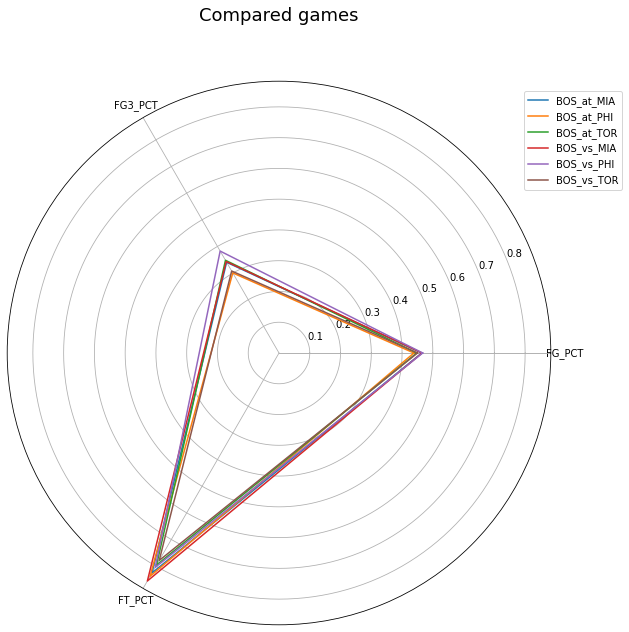

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(polar=True)
plt.plot(label_placement, BOS_at_MIA)
plt.plot(label_placement, BOS_at_PHI)
plt.plot(label_placement, BOS_at_TOR)
plt.plot(label_placement, BOS_vs_MIA)
plt.plot(label_placement, BOS_vs_PHI)
plt.plot(label_placement, BOS_vs_TOR)
lines, labels = plt.thetagrids(np.degrees(label_placement), labels=categories)
plt.title('Compared games', y=1.1, fontdict={'fontsize':18})
plt.legend(labels=['BOS_at_MIA', 'BOS_at_PHI', 'BOS_at_TOR', 'BOS_vs_MIA', 'BOS_vs_PHI', 'BOS_vs_TOR'], loc=(0.95, 0.8));